In [16]:
import csv
import os
import pickle
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from PIL import Image

from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

from keras.applications import vgg16, inception_v3, resnet, xception
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, MaxPooling2D
from keras.models import Model, Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from keras.wrappers.scikit_learn import KerasClassifier

In [3]:
RANDOM_STATE = 42

In [4]:
def load_dataset(target_size):
    x, y = [], []
    base_path = "./data/images/"

    for dir in os.listdir(base_path):
        for image in os.listdir(os.path.join(base_path, dir)):
            image_path = os.path.join(base_path, dir, image)
            image = Image.open(image_path)
            rgb_image = image.copy().convert("RGB")
            x.append(np.array(rgb_image.resize(target_size), dtype=np.uint8))
            y.append(dir)

    return x, y

In [5]:
target_size = (224, 224)

In [6]:
metadata = pd.read_csv("./data/metadata.csv")
meta_filter = metadata[["Channel", "Category"]]
meta_filter = meta_filter.drop_duplicates()
meta_dict = meta_filter.set_index("Channel")["Category"].to_dict()

In [7]:
x, y = load_dataset(target_size)

class: Abroad in Japan


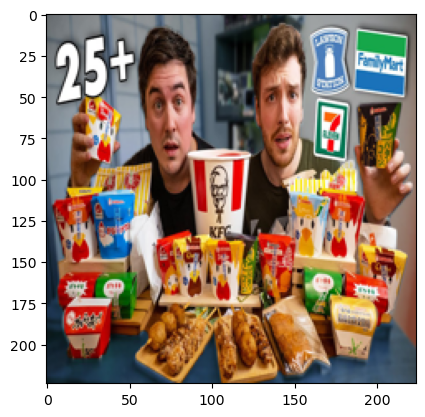

In [8]:
plt.imshow(x[100])
print(f"class: {y[100]}")

In [9]:
print(set(meta_dict.values()))

coarse_dict = {
    'automotive': ['Automobile,Comedy', 'Automobile'],
    'blog': ['Blog,Comedy', 'Blog,Entertainment', 'Blog', 'Blog,Science'],
    'comedy': ['Comedy', 'Comedy,Informative', 'Comedy,Entertainment'],
    'entertainment': ['Entertainment,Blog', 'Entertainment,Comedy', 'Entertainment'],
    'food': ['Food', 'Food,Entertainment'],
    'information': ['Science', 'News', 'Informative'],
    'technology': ['VideoGames', 'Tech,Comedy', 'Tech,News', 'Tech,Informative', 'Tech'],
}

{'Tech,Comedy', 'Informative', 'Entertainment,Comedy', 'Food,Entertainment', 'Automobile', 'Comedy,Informative', 'Automobile,Comedy', 'Science', 'Comedy', 'Blog,Comedy', 'Blog,Entertainment', 'Entertainment,Blog', 'Blog', 'Tech,News', 'Blog,Science', 'Tech', 'Tech,Informative', 'News', 'Food', 'Comedy,Entertainment', 'VideoGames', 'Entertainment'}


In [10]:
y_fine = [meta_dict[item] for item in y]

y_coarse = []
for item in y_fine:
    for key, value in coarse_dict.items():
        if item in value:
            y_coarse.append(key)

In [11]:
print(f"Length Fine: {len(y_fine)} ---  Length Coarse: {len(y_coarse)}")

Length Fine: 2244 ---  Length Coarse: 2244


In [12]:
for i, item in enumerate(y_fine):
    print(f"Fine: {item} --- Coarse: {y_coarse[i]}")

Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Scienc

In [13]:
set_y_coarse = set(y_coarse)
count_dict = {}
for item in set_y_coarse:
    count_dict[item] = y_coarse.count(item)

print(count_dict)

{'information': 660, 'automotive': 261, 'comedy': 174, 'technology': 513, 'entertainment': 164, 'blog': 234, 'food': 238}


In [33]:
with open("./results/Data/CSV/distribution_v2.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Category", "Count"])
    for category, occurence in count_dict.items():
        writer.writerow([category, occurence])

In [14]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_coarse)
y_one_hot = to_categorical(y_encoded)

In [24]:
sm = SMOTE(random_state=RANDOM_STATE)
x = np.array(x)
n_samples, width, height, n_channels = x.shape

x_flat = x.reshape(n_samples, -1)

x, y_one_hot = sm.fit_resample(x_flat, y_one_hot)
x = x.reshape(-1, width, height, n_channels)

In [25]:
value_distribution = pd.DataFrame([le.classes_[np.argmax(line)] for line in y_one_hot])
print(value_distribution.value_counts())

AxisError: axis 1 is out of bounds for array of dimension 1

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y_one_hot, test_size=0.2, random_state=RANDOM_STATE)
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_STATE)
x_train = np.array(x_train)
x_val = np.array(x_val)

print(f"Train Size: {len(y_train)} --- Validation Size: {len(y_val)} --- Test Size: {len(y_test)}")

Train Size: 1436 --- Validation Size: 359 --- Test Size: 449


In [38]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

In [39]:
train_generator = train_datagen.flow(
    x_train, 
    y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x_val,
    y_val,
    batch_size=32,
    shuffle=False
)

In [40]:
custom_model = Sequential()
custom_model.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=target_size+(3,)))
custom_model.add(MaxPooling2D(pool_size=3))
custom_model.add(Conv2D(64, kernel_size=3, activation="relu"))
custom_model.add(MaxPooling2D(pool_size=3))
custom_model.add(Flatten())
custom_model.add(Dense(128, activation="relu"))
custom_model.add(Dropout(0.3))
custom_model.add(Dense(len(le.classes_), activation="softmax"))

custom_model.compile(optimizer=Adam(learning_rate=1e-03), loss="categorical_crossentropy", metrics=["accuracy"])

Epoch 1/20
45/45 [==============================] - 38s 820ms/step - loss: 1.8529 - accuracy: 0.2897 - val_loss: 1.7439 - val_accuracy: 0.3287 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - 36s 797ms/step - loss: 1.6660 - accuracy: 0.3489 - val_loss: 1.6500 - val_accuracy: 0.3649 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - 37s 823ms/step - loss: 1.5450 - accuracy: 0.4095 - val_loss: 1.6042 - val_accuracy: 0.4095 - lr: 0.0010
Epoch 4/20
45/45 [==============================] - 37s 810ms/step - loss: 1.4312 - accuracy: 0.4708 - val_loss: 1.5488 - val_accuracy: 0.4708 - lr: 0.0010
Epoch 5/20
45/45 [==============================] - 36s 800ms/step - loss: 1.3883 - accuracy: 0.5014 - val_loss: 1.5142 - val_accuracy: 0.4791 - lr: 0.0010
Epoch 6/20
45/45 [==============================] - 36s 797ms/step - loss: 1.3038 - accuracy: 0.5348 - val_loss: 1.4417 - val_accuracy: 0.4652 - lr: 0.0010
Epoch 7/20
45/45 [==============================] - 38s 837ms/st

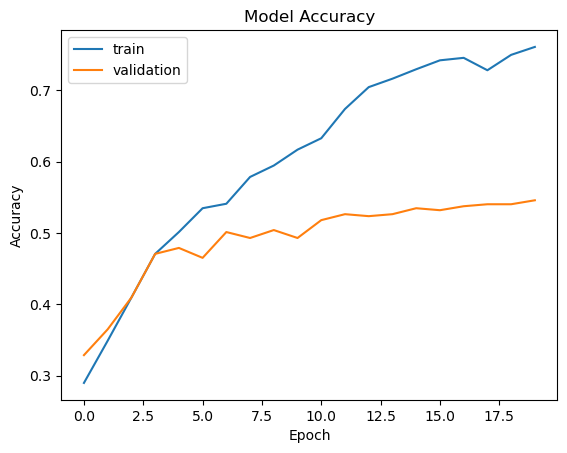

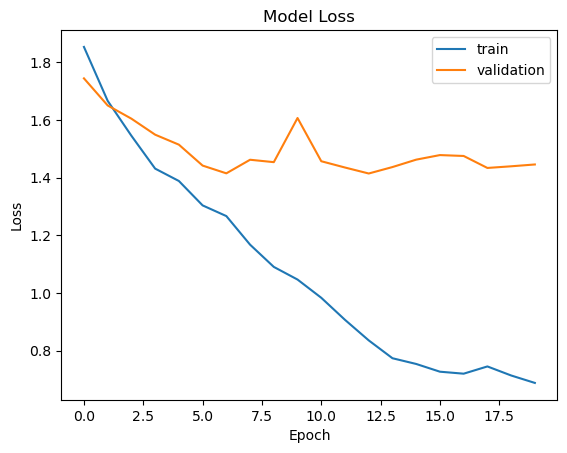

In [41]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

history = custom_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr],
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

15/15 [==============================] - 1s 88ms/step
Accuracy of 45.66%


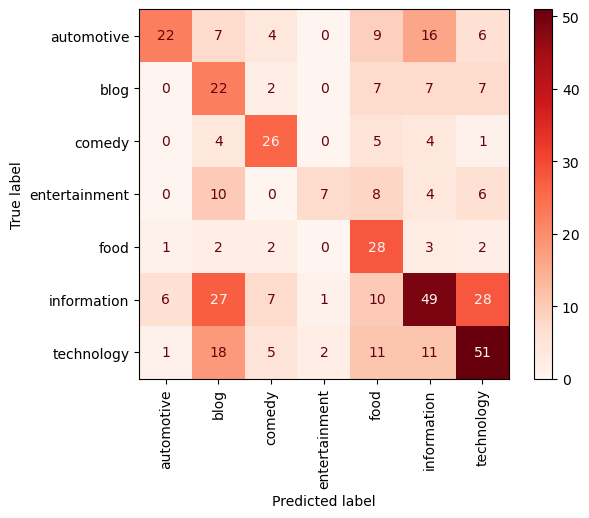

In [42]:
pred = custom_model.predict(x_test)
predictions = np.argmax(pred, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
acc = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f"Accuracy of {round(acc*100, 2)}%")
cm_display = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
cm_display.plot(cmap="Reds", xticks_rotation=90)